In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import urllib.request
import tensorflow_datasets as tfds
import time
import re

In [25]:
tf.__version__

'2.12.0'

# Positional Encoding

In [26]:
class PositionalEncoding(tf.keras.layers.Layer):
    # tf.keras.layers.Layer를 상속
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    # 각도 계산
    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))  # 1 / 10000&(2i/d_model)
        return pos * angle_rates

    # positional encoding 계산
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

        # 짝수 인덱스에는 sin 함수 적용
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # 홀수 인덱스에는 cos 함수 적용
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        # 위에서 계산한 결과를 저장
        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    # 객체가 호출될 때 실행되는 함수
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

포지셔널 인코딩의 입력: 입력 시퀀스의 각 단어의 위치, 임베딩 벡터의 차원 수

포지셔널 인코딩의 출력: 해당 위치의 단어에 대한 고차원 벡터. 이 벡터는 입력 시퀀스의 각 단어의 임베딩 벡터에 추가되어 단어의 위치를 고려할 수 있게 한다.

사인과 코사인 함수를 사용하는 이유: 특정 위치에 대한 정보를 담기 위함. 두 함수는 주기적으로 연속적인 값을 갖기 때문에, 위치 정보를 연속적으로 주기적인 형태로 표현할 수 있다. Transformer 모델은 RNN이나 LSTM과 달리 모든 입력을 동시에 처리하므로 기본적으로 입력 데이터의 순서 정보를 인식하지 못하기 때문에, 단어의 위치 정보가 입력 데이터에 포함되어야 한다.

홀수와 짝수 인덱스에 사인과 코사인을 번갈아 가며 사용하는 이유: 포지셔널 인코딩의 벡터 공간을 더 풍부하게 만들기 위함이다. 사인 함수와 코사인 함수는 입력값이 같은 주기로 변할 때 같은 값을 출력하기 때문에, 같은 간격으로 떨어져 있는 단어들에 대한 포지셔널 인코딩 값이 같아지는 경우가 있다. 이러한 상황을 방지하기 위해 사인 함수와 코사인 함수를 번갈아가며 사용함으로써 각 위치에 대한 인코딩 값의 다양성을 증가시키고, 모델이 단어의 절대적인 위치 정보를 더 잘 인식할 수 있게 한다.

In [27]:
layer = PositionalEncoding(50, 512)
x = tf.random.uniform((1, 50, 512))  # 예시 입력
out = layer(x)

In [28]:
print(type(layer))
print(type(x))
print(type(out))

<class '__main__.PositionalEncoding'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


Positional Encoding 테스트

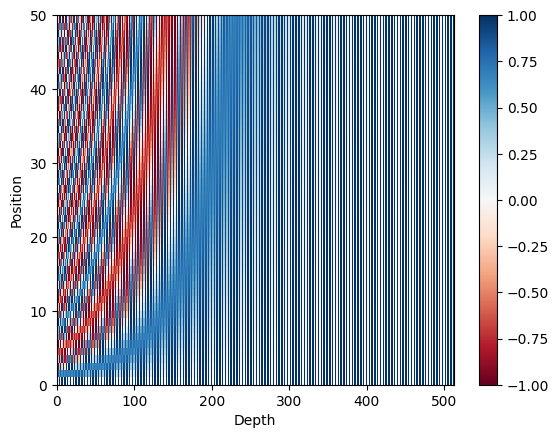

In [29]:
pos_encoding = PositionalEncoding(50, 512)  # 50개의 단어와 512 차원의 임베딩
pos_encoding = pos_encoding.pos_encoding.numpy()  # numpy 배열로 변환

# 결과 시각화
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')  # x축은 임베딩 벡터의 차원
plt.xlim((0, 512))
plt.ylabel('Position')  # y축은 단어의 위치
plt.colorbar()
plt.show()

# Multi-head Attention과 Scaled dot-product Attention

scaled dot-product attention

In [30]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

Multi-head Attention

In [31]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output, attention_weights

멀티 헤드 어텐션 작동 테스트

In [32]:
# 테스트 데이터 생성
batch_size = 64
seq_len = 50
d_model = 512
num_heads = 8

# 임의의 마스크 생성 (예시로 None 사용)
mask = None

# 임의의 시퀀스 생성
v = k = q = tf.random.uniform((batch_size, seq_len, d_model))

# 멀티 헤드 어텐션 레이어 생성
mha = MultiHeadAttention(d_model, num_heads)

# 멀티 헤드 어텐션 호출
output, attn_weights = mha(v, k, q, mask)

print("Output shape: ", output.shape)
print("Attention weights shape: ", attn_weights.shape)

Output shape:  (64, 50, 512)
Attention weights shape:  (64, 8, 50, 50)


멀티 헤드 어텐션 레이어가 입력 시퀀스와 동일한 형태의 출력을 생성하는 것을 볼 수 있다. 이는 각 입력 위치가 어텐션 메커니즘을 통해 새롭게 계산된 표현을 가지고 있다는 것을 의미한다.

In [33]:
print(tf.reduce_sum(attn_weights, axis=-1))

tf.Tensor(
[[[1.         0.9999999  1.         ... 1.         1.         1.0000001 ]
  [0.99999994 1.         1.         ... 1.         1.         0.99999994]
  [1.         1.0000001  0.99999994 ... 1.         1.0000001  1.        ]
  ...
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.0000001  1.0000001  1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]]

 [[1.         1.         1.         ... 1.         0.99999994 1.        ]
  [1.         1.         1.         ... 1.0000001  0.9999999  0.99999994]
  [1.         1.         1.         ... 1.         0.99999994 1.        ]
  ...
  [1.         1.         1.         ... 1.         0.99999994 0.9999999 ]
  [1.         1.         1.         ... 0.99999994 1.         1.        ]
  [1.         1.         1.0000001  ... 1.         0.99999994 1.        ]]

 [[1.0000001  1.         1.         ... 1.0000001  0.99999994 0.99999994]
  [0.999999

그리고 각 입력 위치에서 가중치의 합이 거의 모두 1로 수렴하는 것을 통해 멀티 헤드 어텐션 레이어가 제대로 작동한다는 것을 확인할 수 있다.

# Additive Attention

In [34]:
class AdditiveAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(AdditiveAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

# Position-Wise Feed-Forward Neural Network

In [35]:
class PositionWiseFeedForwardNetwork(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        super(PositionWiseFeedForwardNetwork, self).__init__()

        self.fc1 = tf.keras.layers.Dense(dff, activation='relu')  # (배치 사이즈, 시퀀스 길이, dff)
        self.fc2 = tf.keras.layers.Dense(d_model)  # (배치 사이즈, 시퀀스 길이, 임베딩 벡터 차원)

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# 패딩 마스크

시퀀스 길이를 동일하게 맞추기 위해 추가된 패딩 토큰(padding token)을 처리하는 데 사용된다. 시퀀스 데이터를 처리할 때, 배치 내의 모든 시퀀스가 동일한 길이를 가져야 하는 경우가 많은데, 이 때 길이가 짧은 시퀀스에 패딩 토큰을 추가하여 모든 시퀀스 길이를 동일하게 맞추는 역할을 한다.

In [36]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]  # (배치 사이즈, 1, 1, 키 문장 길이)

# 인코더 구현

In [37]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        # Multi-Head Attention과 Position-Wise FFNN을 사용
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionWiseFeedForwardNetwork(d_model, dff)

        # 레이어 정규화 정의
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # 드롭아웃 정의
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.multi_head_attention(x, x, x, mask)  # 첫 번째 서브층: MultiHead Attention
        attn_output = self.dropout1(attn_output, training=training)  # 드롭아웃
        out1 = self.layernorm1(x + attn_output)  # 레이어 정규화 및 잔차 연결

        ffn_output = self.ffn(out1)  # 두 번째 서브층: FFNN
        ffn_output = self.dropout2(ffn_output, training=training)  # 드롭아웃
        out2 = self.layernorm2(out1 + ffn_output)  # 레이어 정규화 및 잔차 연결

        return out2

In [38]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model  # 데이터 차원
        self.num_layers = num_layers  # 레이어 수

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)  # 단어 임베딩
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, self.d_model)  # 포지셔널 인코딩

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)  # 드롭아웃

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)  # 임베딩 추가
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # 임베딩 스케일링
        x = self.pos_encoding(x) # 포지셔널 인코딩

        x = self.dropout(x, training=training)  # 드롭아웃

        # 레이어 수만큼 레이어 쌓기
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (배치 사이즈, 시퀀스 길이(단어 개수), 데이터 차원)

인코더 테스트

In [39]:
# 테스트에 사용할 더미 입력 데이터 생성
input_data = np.random.randint(10000, size=(10, 50))  # 배치 사이즈 10, 시퀀스 길이 50

encoder = Encoder(num_layers=6, d_model=512, num_heads=8, dff=2048, input_vocab_size=10000, maximum_position_encoding=1000)
output = encoder(input_data, training=False, mask=None)

print("Output Shape :", output.shape)

Output Shape : (10, 50, 512)


# Look-Ahead Mask

In [40]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 마스킹하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

# 디코더

In [41]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        # 멀티 헤드 어텐션 정의
        self.multi_head_attention_1 = MultiHeadAttention(d_model, num_heads)
        self.multi_head_attention_2 = MultiHeadAttention(d_model, num_heads)

        # 포지션 와이즈 피드 포워드 신경망 정의
        self.ffn = PositionWiseFeedForwardNetwork(d_model, dff)

        # 레이어 정규화 정의
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # 드롭아웃 정의
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.multi_head_attention_1(x, x, x, look_ahead_mask)  # 첫 번째 서브층: 멀티 헤드 어텐션(look-ahead 마스크, 셀프 어텐션)
        attn1 = self.dropout1(attn1, training=training)  # 드롭아웃
        out1 = self.layernorm1(attn1 + x)  # 레이어 정규화 및 잔차 연결

        attn2, attn_weights_block2 = self.multi_head_attention_2(enc_output, enc_output, out1, padding_mask)  # 두 번째 서브층: 멀티 헤드 어텐션(패딩 마스크)
        attn2 = self.dropout2(attn2, training=training)  # 드롭아웃
        out2 = self.layernorm2(attn2 + out1)  # 레이어 정규화 및 잔차 연결

        ffn_output = self.ffn(out2)  # 세 번째 서브층: 포지션 와이즈 FFNN
        ffn_output = self.dropout3(ffn_output, training=training)  # 드롭아웃
        out3 = self.layernorm3(ffn_output + out2)  # 레이어 정규화 및 잔차 연결

        return out3, attn_weights_block1, attn_weights_block2

In [42]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model  # 데이터 차원
        self.num_layers = num_layers  # 레이어 수

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)  # 단어 임베딩
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, self.d_model)  # 포지셔널 인코딩

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]  # 각 레이어 정의(세 서브층이 하나의 레이어)

        self.dropout = tf.keras.layers.Dropout(rate)  # 드롭아웃

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights  # (배치 사이즈, 목표 시퀀스 길이, 모델의 임베딩 차원), 가중치

목표 시퀀스 길이: 예를 들어 기계 번역을 수행할 때에는 목표 언어에 대한 번역된 문장의 길이를 말한다. 즉, 출력 시퀀스의 길이가 된다.

모델의 임베딩 차원: 각 단어나 토큰이 모델에 의해 표현되는 벡터의 차원 수이다. 모델의 복잡성과 능력을 결정하는 중요한 파라미터이다.

# Transformer 모델 생성

In [43]:
def transformer(num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1):
    # 인코더, 디코더 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 패딩 & 룩어헤드 마스크 생성
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None),
                                              name='enc_padding_mask')(inputs)
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None),
                                             name='look_ahead_mask')(dec_inputs)
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None),
                                              name='dec_padding_mask')(inputs)

    # 인코더
    encoder = Encoder(num_layers, d_model, num_heads, dff,
                      input_vocab_size, pe_input, rate)
    enc_output = encoder(inputs, training=True, mask=enc_padding_mask)

    # 디코더
    decoder = Decoder(num_layers, d_model, num_heads, dff,
                      target_vocab_size, pe_target, rate)
    dec_output, _ = decoder(dec_inputs, enc_output, training=True,
                            look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)

    # 완전 연결층(Dense layer)
    outputs = tf.keras.layers.Dense(target_vocab_size, name='outputs')(dec_output)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs)


Transformer 테스트

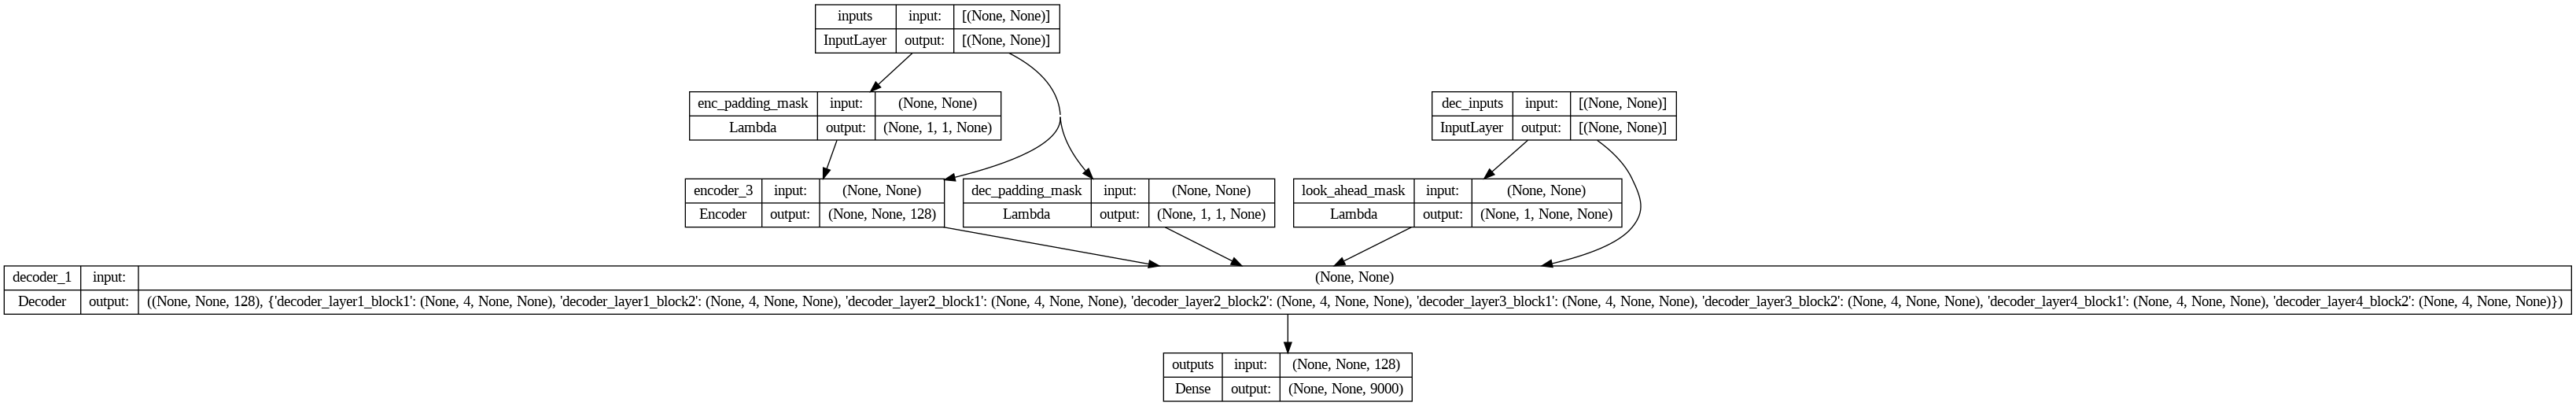

In [44]:
transformer_test = transformer(
    num_layers = 4,  # 인코더와 디코더의 레이어 개수
    d_model = 128,  # 임베딩 벡터의 차원
    num_heads = 4,  # 멀티 헤드 어텐션 메커니즘의 헤드 수
    dff = 512,  # 피드포워드 네트워크 은닉층의 뉴런 수
    input_vocab_size = 9000,  # 입력의 단어 집합 크기
    target_vocab_size = 9000,  # 출력의 단어 집합 크기
    pe_input = 10000,  # 입력 최대 포지셔널 인코딩 값
    pe_target = 10000,  # 출력 최대 포지셔널 인코딩 값
    rate = 0.3  # 드롭아웃 비율
)

tf.keras.utils.plot_model(
    transformer_test, to_file='transformer_test.png', show_shapes=True
)

# **챗봇 구현**

## 데이터 전처리

### 데이터 가져오기

In [46]:
train_data = pd.read_csv('Data.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [47]:
print('샘플 크기 :', train_data.shape)

샘플 크기 : (11823, 3)


In [48]:
questions = []
for sentence in train_data['Q']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

answers = []
for sentence in train_data['A']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [49]:
# print(np.array(questions).shape)
# print(np.array(answers).shape)

print(len(questions))
print(len(answers))

11823
11823


### 단어 집합 생성

In [50]:
# Q와 A column을 합친 후 중복을 제거하여 전체 문장 집합 생성
sentences = questions + answers

# SubwordTextEncoder를 사용하여 단어 집합 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    sentences, target_vocab_size=2**13)  # target_vocab_size: 단어 집합의 크기

# 생성된 단어 집합 출력
print(tokenizer.subwords)

# 시작 토큰과 종료 토큰에 대한 정수 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

[' .', ' ?', '거예요', '수_', '게_', '너무_', '더_', '거_', '좋아하는_', '는_', '이_', '을_', '잘_', '도_', ' .  ', '고_', '요', '것_', '많이_', '안_', '좋은_', '같아요', '한_', '좀_', '있어요', '싶어', '가_', '나_', '에_', '있을_', '지_', '해보세요', '은_', '사람_', '할_', '해', '같아', '네', '면_', '건_', ' !', '사람이_', '를_', '마세요', '다_', '하고_', '지', '하는_', '보세요', '죠', '어', '서_', '내가_', '의_', '다', '내_', '이제_', '마음이_', '나', '다른_', '썸_', '만_', '그_', '어떻게_', '있는_', '왜_', '싶다', '세요', '다시_', '시간이_', '수도_', '없어', '것도_', '또_', '좋을_', '오늘_', '정말_', '가', '이', '같이_', '네요', '될_', '해요', '자꾸_', '걸_', '있어', '하세요', '없어요', '일_', '제가_', '길_', '바랄게요', '로_', '까', '돼요', '하면_', '봐요', '할까', '때_', '저도_', '으로_', '먼저_', '있을까', '에서_', '주세요', '그런_', '헤어진지_', '이별_', '될까', '기_', '고', '진짜_', '나를_', '야', '마음을_', '여자친구가_', '기', '좋아요', '없는_', '계속_', '남자친구가_', '혼자_', '해도_', '이별', '못_', '드세요', '줄_', '않아요', '먹고_', '는데_', '좋죠', '하지_', '일이_', '힘든_', '아', '바랍니다', '마음_', '그럴_', '좋아', '보고_', '데_', '돼', '했어', '만큼_', '생각해요', '말해보세요', '나봐요', '자', '주', '연락_', '사랑이_', '좋겠어요', '친구가_', 

In [51]:
tokenizer.vocab_size

8178

In [52]:
print(START_TOKEN)
print(END_TOKEN)
print(VOCAB_SIZE)

[8178]
[8179]
8180


### 각 단어를 정수로 변환

In [53]:
# 문장의 최대 토큰 길이
MAX_LENGTH = 40

def tokenize(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []  # 토큰화 결과

  # 모든 입력 문장과 출력 문장에 대해 각 문장을 토큰화하고 정수 인코딩. 모든 문장에는 시작 토큰과 종료 토큰 추가
  for (sentence1, sentence2) in zip(inputs, outputs):
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 토큰화 결과 추가
    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 문장의 끝에 패딩 적용
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [54]:
questions, answers = tokenize(questions, answers)

In [55]:
print(questions[:3])
print(answers[:3])

[[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [8178 7971   47  919 7954  998 1716 8179    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [8178 7973 1435 4653 7954 3652   67 8179    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [8178 1830 5502    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 

In [56]:
BATCH_SIZE = 64

# tf.data.Dataset API를 이용하여 파이프라인을 구축
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,  # 인코더의 입력
        'dec_inputs': answers[:, :-1]  # 디코더의 입력은 종료 토큰을 제외
    },
    {
        'outputs': answers[:, 1:]  # 디코더의 실제 값은 시작 토큰을 제외
    },
))

# 데이터셋을 배치 단위로 나눔
dataset = dataset.batch(BATCH_SIZE)

### 배치 테스트: 첫 번째 배치의 첫 문장이 잘 출력되는지 확인하기

In [57]:
for batch in dataset.take(1):
    inputs, targets = batch
    print("[인코더의 입력]\n", inputs['inputs'][0])
    print("\n[디코더의 입력]\n", inputs['dec_inputs'][0])
    print("\n[디코더의 실제 값]\n", targets['outputs'][0])

[인코더의 입력]
 tf.Tensor(
[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32)

[디코더의 입력]
 tf.Tensor(
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int32)

[디코더의 실제 값]
 tf.Tensor(
[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int32)


## 학습률 정의

In [58]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

학습률 정의

Text(0.5, 0, 'Train Step')

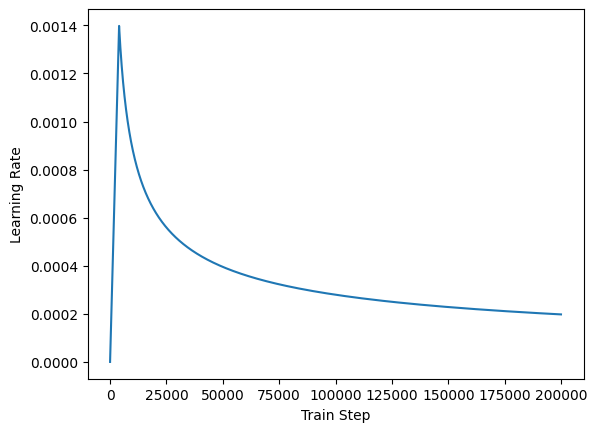

In [59]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

CustomSchedule이 잘 작동하는지 테스트

Step: 1, Learning Rate: 3.49385601339236e-07
Step: 201, Learning Rate: 7.02265024301596e-05
Step: 401, Learning Rate: 0.00014010362792760134
Step: 601, Learning Rate: 0.00020998074614908546
Step: 801, Learning Rate: 0.0002798578643705696
Step: 1001, Learning Rate: 0.0003497349680401385
Step: 1201, Learning Rate: 0.00041961210081353784
Step: 1401, Learning Rate: 0.0004894892335869372
Step: 1601, Learning Rate: 0.0005593663081526756
Step: 1801, Learning Rate: 0.000629243440926075
Step: 2001, Learning Rate: 0.0006991205736994743
Step: 2201, Learning Rate: 0.0007689977646805346
Step: 2401, Learning Rate: 0.000838874839246273
Step: 2601, Learning Rate: 0.0009087519720196724
Step: 2801, Learning Rate: 0.0009786291047930717
Step: 3001, Learning Rate: 0.001048506237566471
Step: 3201, Learning Rate: 0.0011183832539245486
Step: 3401, Learning Rate: 0.0011882605031132698
Step: 3601, Learning Rate: 0.0012581375194713473
Step: 3801, Learning Rate: 0.0013280146522447467
Step: 4001, Learning Rate: 0.

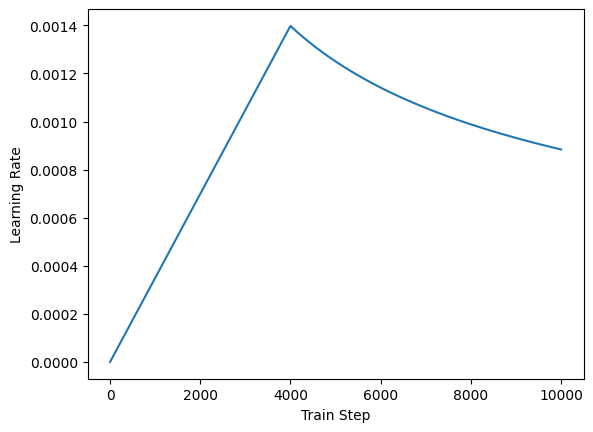

In [60]:
# CustomSchedule 테스트
d_model = 128
learning_rate = CustomSchedule(d_model)

for step in range(1, 10000, 200):
  lr = learning_rate(step)
  print(f"Step: {step}, Learning Rate: {lr}")

# 학습률 그래프로 출력
steps = range(1, 10000)
lrs = [learning_rate(step) for step in steps]

plt.plot(steps, lrs)
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

## 손실함수 정의

In [61]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))  # y_true: (배치 크기, 문장의 최대 길이 - 1)

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)  # y_pred가 확률분포가 아닌 로짓을 나타냄. 손실을 즉시 최소화하지 않고 나중에 수행함.

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)  # y_true 값이 0이 아닌 위치에는 1, 0인 위치에는 0인 마스크 생성. 0은 패딩된 위치를 의미한다.
  loss = tf.multiply(loss, mask)  # 앞서 계산한 손실에 마스크 적용. 패딩된 위치의 손실은 0으로, 패딩되지 않은 위치의 손실은 그대로 유지한다.

  return tf.reduce_mean(loss)  # 모든 위치의 손실의 평균을 반환

## 모델 생성

하이퍼 파라미터 정의

In [62]:
transformer_model = transformer(
    num_layers = 4,  # 인코더와 디코더의 레이어 개수
    d_model = 128,  # 임베딩 벡터의 차원
    num_heads = 4,  # 멀티 헤드 어텐션 메커니즘의 헤드 수
    dff = 512,  # 피드포워드 네트워크 은닉층의 뉴런 수
    input_vocab_size = 9000,  # 입력의 단어 집합 크기
    target_vocab_size = 9000,  # 출력의 단어 집합 크기
    pe_input = 10000,  # 입력 최대 포지셔널 인코딩 값
    pe_target = 10000,  # 출력 최대 포지셔널 인코딩 값
    rate = 0.3  # 드롭아웃 비율
)

모델 컴파일

In [63]:
learning_rate = CustomSchedule(d_model)

# beta: 이동 평균을 계산할 때 사용되는 가중치 과거 그래디언트 고려 비율
# epsilon: 0으로 나누는 것을 방지하기 위해 분모에 추가되는 작은 상수
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 주어진 레이블 y_true와 예측값 y_pred에 대한 정확도를 계산하는 함수
def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

transformer_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

모델 훈련

In [64]:
EPOCHS = 50
transformer_model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
185/185 [==============================] - 109s 369ms/step - loss: 1.5219 - accuracy: 0.0193
Epoch 2/50
185/185 [==============================] - 13s 72ms/step - loss: 1.3243 - accuracy: 0.0265
Epoch 3/50
185/185 [==============================] - 13s 72ms/step - loss: 1.1152 - accuracy: 0.0492
Epoch 4/50
185/185 [==============================] - 13s 71ms/step - loss: 1.0217 - accuracy: 0.0497
Epoch 5/50
185/185 [==============================] - 13s 71ms/step - loss: 0.9653 - accuracy: 0.0506
Epoch 6/50
185/185 [==============================] - 13s 72ms/step - loss: 0.9294 - accuracy: 0.0514
Epoch 7/50
185/185 [==============================] - 13s 71ms/step - loss: 0.9061 - accuracy: 0.0524
Epoch 8/50
185/185 [==============================] - 16s 85ms/step - loss: 0.8877 - accuracy: 0.0532
Epoch 9/50
185/185 [==============================] - 13s 73ms/step - loss: 0.8702 - accuracy: 0.0539
Epoch 10/50
185/185 [==============================] - 13s 72ms/step - loss: 0.8

입력 전처리

In [65]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [66]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더 예측
  for i in range(MAX_LENGTH):
    predictions = transformer_model(inputs=[sentence, output], training=False)

    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 종료 토큰이면 예측 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [67]:
def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [82]:
output = predict("안녕?")

Input: 안녕?
Output: 다가가는 건 그 사람도 무엇인히 표현하요 .


In [83]:
output = predict("영화 볼래?")

Input: 영화 볼래?
Output: 무슨 계기가 있었나봐요 .


In [84]:
output = predict("축구 할래?")

Input: 축구 할래?
Output: 많이 당황했겠어요 .


In [85]:
output = predict("너무 더워")

Input: 너무 더워
Output: 짝사랑 앞에 앞에 앞에 앞에 장받고 때문이죠 .


In [86]:
output = predict("배고파")

Input: 배고파
Output: 짝사랑 문제가 신청 해도 좋겠어요 .
